# Tensorflow Object Detection on Static Image and on Video

Tensorflow Object Detection allows to detect many classes of object on static images and on video. The project shows how object detection can be performed with tensorflow object detection API. 

## Import packages

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import numpy as np
import os
import pathlib
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from PIL import Image
from IPython.display import display

## Function to load tensorflow object detection pretrained model 

In [5]:
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
      fname=model_name, 
      origin=base_url + model_file,
      untar=True)
    print(base_url + model_file)
    print(model_dir)
    model_dir = pathlib.Path(model_dir)/"saved_model"
    print(model_dir)
    model = tf.saved_model.load(str(model_dir))

    return model

In [6]:
model = load_model('ssd_mobilenet_v1_coco_2017_11_17')

http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz
C:\Users\Herkules\.keras\datasets\ssd_mobilenet_v1_coco_2017_11_17
C:\Users\Herkules\.keras\datasets\ssd_mobilenet_v1_coco_2017_11_17\saved_model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Making prediction classes available

In [7]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'tensorflow/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Function to run inference for a single image

In [8]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

## Drawing boxes for detected objects

In [9]:
def get_image_from_inference(model, image_np):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    #image_np = np.array(image_np)
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    # Visualization of the results of a detection.
    #print(image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
    #print(image_np)
    #return Image.fromarray(image_np)
    return image_np

## Displaying boxes around detected objects

In [10]:
def show_inference(model, image_np):

    display(Image.fromarray(get_image_from_inference(model, image_np.copy())))

## Running object detection on static image

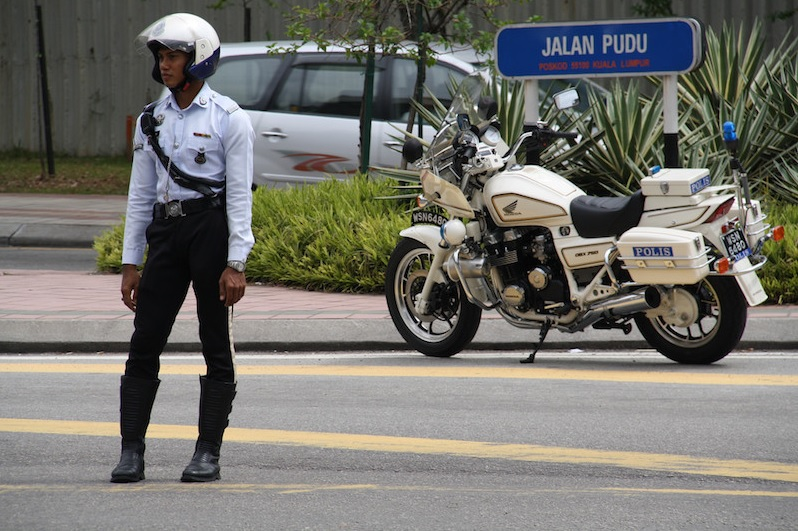

In [11]:
# Open image
img = cv2.imread("Bild_City.JPG")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

display(Image.fromarray(img_rgb))

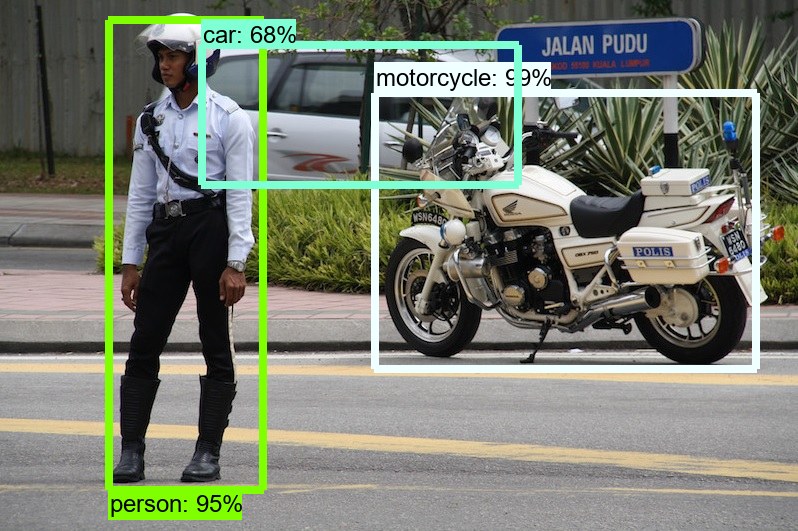

In [12]:
show_inference(model, img_rgb)

## Running object detection on video

In [13]:
cap = cv2.VideoCapture("VIDEO5.mp4")

cv2.namedWindow('VIDEO3.mp4',cv2.WINDOW_NORMAL)
cv2.resizeWindow('VIDEO3.mp4', (600,400))
while True:
    _, frame = cap.read()

    if type(frame).__module__ != np.__name__ :
        break
    img_final = get_image_from_inference(model,frame.copy())
    cv2.imshow("VIDEO3.mp4-b", cv2.resize(frame, (600,400)))
    cv2.imshow("VIDEO3.mp4", cv2.resize(img_final, (600,400)))
    
    key = cv2.waitKey(20)
    if key == 10:
        break
cap.release()
cv2.destroyAllWindows()

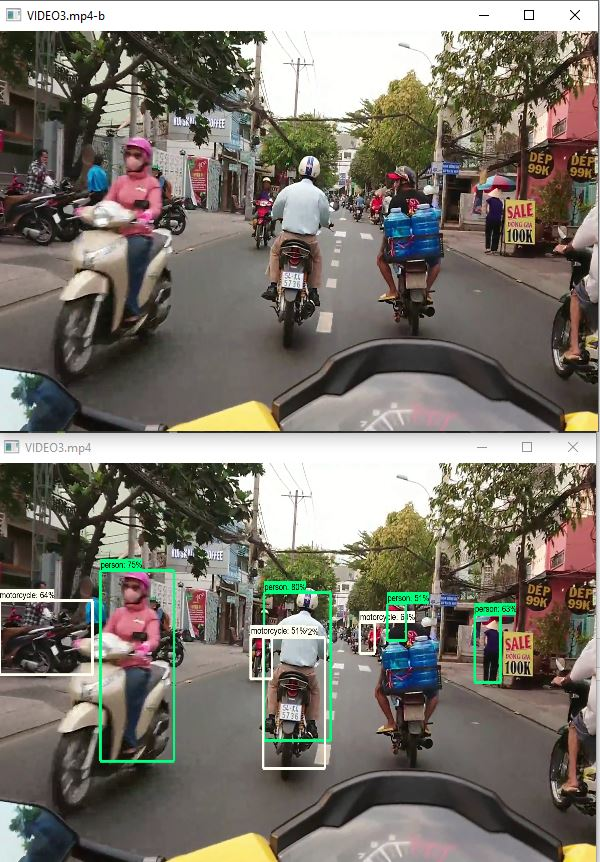

In [14]:
# Open image
img = cv2.imread("Video-Image-OD.JPG")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

display(Image.fromarray(img_rgb))